In [22]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='SQL3306Server!!',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files

folder_path = "C:\\Users\\Aayush\\Documents\\SQL Server Management Studio\\31 Day of Data Analytic Project\\Day 16 Target Sales Analysis\\Dataset"



def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(host ="localhost",
                            username ="root",
                            password ="SQL3306Server!!",
                            database = "ecommerce")

cur = db.cursor()

<b> List all unique cities where customers are located. </b>

In [24]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=['City'])

df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


<b> Count the number of orders placed n 2017.</b>

In [26]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data =cur.fetchall()

data[0][0]

135303

<b> Find the total sales per category</b>

In [27]:
query = """select P.product_category, 
Round(sum(Q.payment_value),2) as total_sales
from products P
join order_items O 
on P.product_id = O.product_id
Join payments Q
on Q.order_id = O.order_id
Group by P.product_category
order by total_sales DESC"""

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales'])

df

,Category,Sales
0,bed table bath,46238949.12
1,HEALTH BEAUTY,44749074.22
2,computer accessories,42803922.05
3,Furniture Decoration,38614762.58
4,Watches present,38588850.32
...,...,...
69,PC Gamer,58709.61
70,House Comfort 2,46184.58
71,cds music dvds,32384.61
72,Fashion Children's Clothing,21213.09


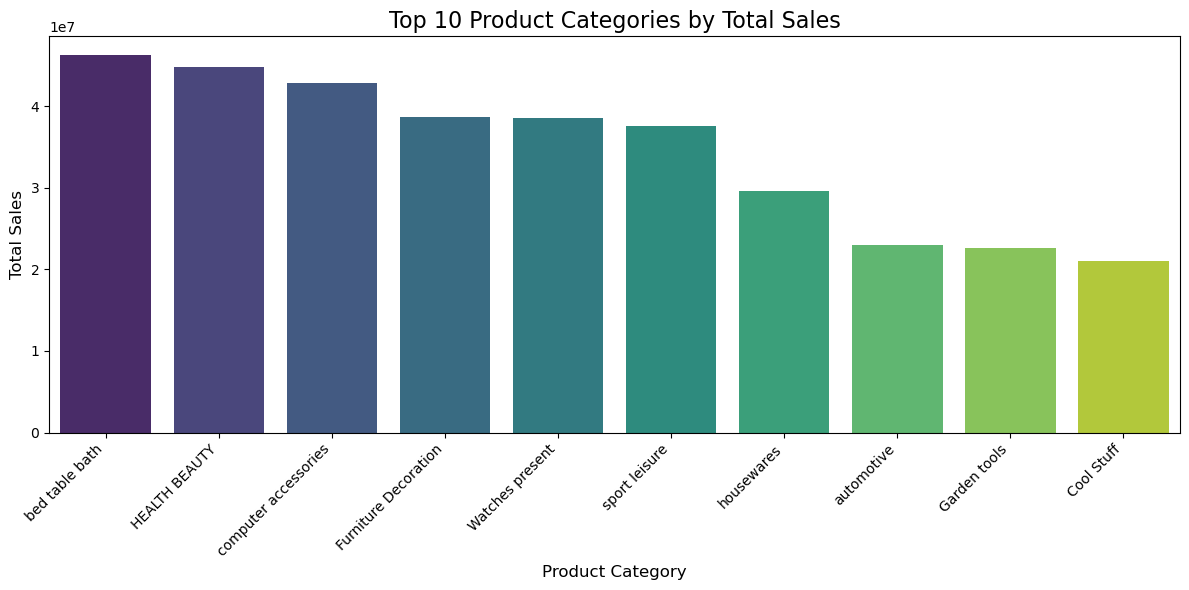

In [28]:
top_10_df = df.sort_values(by='Sales', ascending=False).head(10)


plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_df, x='Category', y='Sales', palette='viridis')

plt.xticks(rotation=45, ha='right') 
plt.title('Top 10 Product Categories by Total Sales', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()


<b> Calculate the percentage of orders that were paid in installments</b>


In [29]:
query = """Select 
       ( (sum(
        case when payment_installments >= 1 Then 1
        Else 0
        End)) / count(*)) * 100 As order_percentage
    From payments

"""

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

<b> Find the average number of products per order, grouped by customer city.</b>


In [30]:
query = """With count_order as(
select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)
Select customers.customer_city, Round(avg(count_order.order_count),2) as avg_order
from count_order
join customers
on count_order.customer_id = customers.customer_id
group by  customers.customer_city
order by avg_order DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['City','Average order'])
df

,City,Average order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
...,...,...
4105,sao mamede,9.00
4106,sambaiba,9.00
4107,japaratuba,9.00
4108,tuiuti,9.00


<b> Calculate the total revenue generated by each sellet and rank them by revenue </b>

In [35]:
query = """With top_seller As(
    SELECT 
    order_items.seller_id,
    ROUND(SUM(payments.payment_value), 2) total_revenue
FROM
    order_items
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id
    )
    Select *, 
        Rank()over(order by total_revenue DESC) as top_seller_rank
        From top_seller"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Sellers','Revenue','Rank'])

df.head(8)

,Sellers,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,4564502.17,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2773998.36,2
2,4a3ca9315b744ce9f8e9374361493884,2711207.43,3
3,1f50f920176fa81dab994f9023523100,2612280.78,4
4,53243585a1d6dc2643021fd1853d8905,2564127.72,5
5,da8622b14eb17ae2831f4ac5b9dab84a,2449973.87,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,2377495.09,7
7,955fee9216a65b617aa5c0531780ce60,2126900.70,8


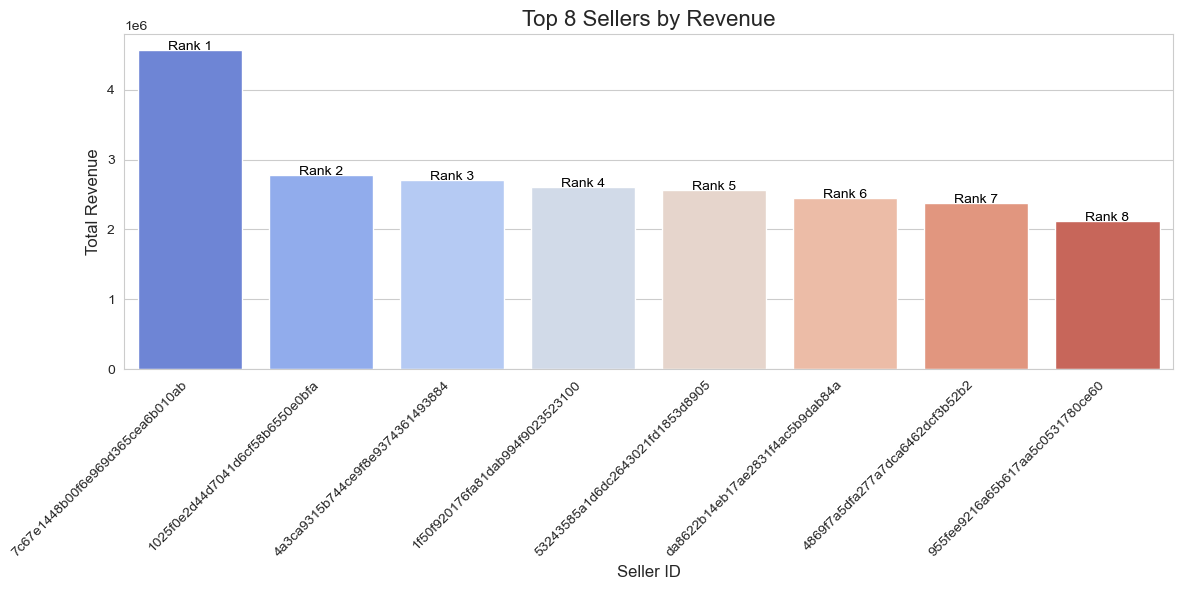

In [37]:

top_sellers_df = df.head(8)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_sellers_df, x='Sellers', y='Revenue', palette='coolwarm')


plt.xticks(rotation=45, ha='right')  
plt.title('Top 8 Sellers by Revenue', fontsize=16)
plt.xlabel('Seller ID', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)


for index, row in top_sellers_df.iterrows():
    plt.text(index, row['Revenue'] + 100, f"Rank {row['Rank']}", ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [39]:
## Identify the top 5 best-selling products on both revenue and quantity sold

query = """SELECT 
    products.product_id,
    products.product_category,
    ROUND(SUM(order_items.price * order_items.order_item_id),
            2) AS total_revenue
FROM
    order_items
        JOIN
    products ON order_items.product_id = products.product_id
GROUP BY 1 , 2
ORDER BY 3 DESC
LIMIT 5"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product_id','Category','Revenue'])

df

,Product_id,Category,Revenue
0,bb50f2e236e5eea0100680137654686c,HEALTH BEAUTY,634365.00
1,5769ef0a239114ac3a854af00df129e4,fixed telephony,544320.00
2,6cdd53843498f92890544667809f1595,HEALTH BEAUTY,518018.39
3,d1c427060a0f73f6b889a5c7c61f2ac4,computer accessories,458463.51
4,d6160fb7873f184099d9bc95e30376af,PCs,440094.06


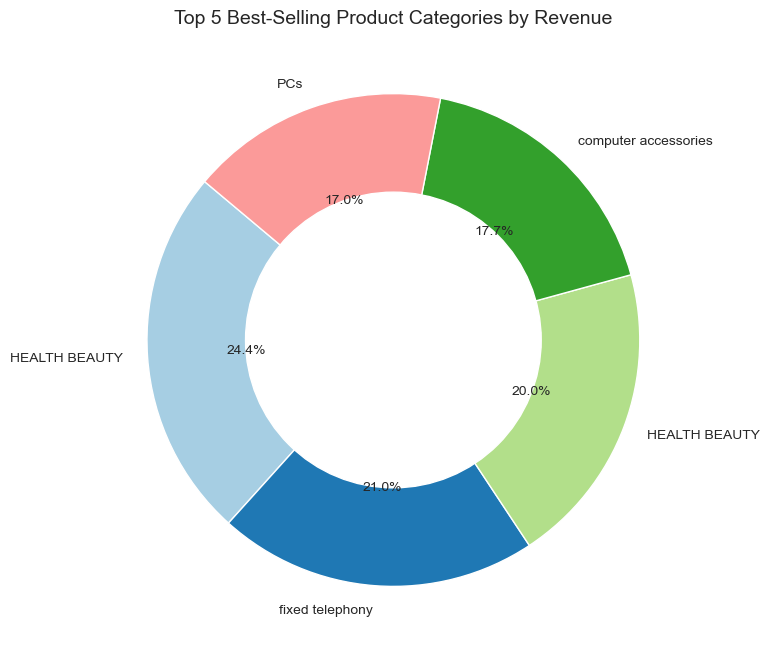

In [40]:
categories = df['Category']
revenues = df['Revenue']

plt.figure(figsize=(8, 8))
plt.pie(
    revenues,
    labels=categories,
    autopct='%1.1f%%', 
    startangle=140,
    colors=plt.cm.Paired.colors, 
    wedgeprops={'edgecolor': 'white'} 
)

center_circle = plt.Circle((0, 0), 0.6, color='white')
plt.gca().add_artist(center_circle)


plt.title('Top 5 Best-Selling Product Categories by Revenue', fontsize=14)


plt.show()


In [58]:
  ## Most Loyal Customers

query = """SELECT 
    customers.customer_id,
    COUNT(orders.order_id) AS frequent_purchase,
    SUM(order_items.price * order_items.order_item_id) AS total_purchase
FROM
    customers
        JOIN
    orders ON customers.customer_id = orders.customer_id
        JOIN
    order_items ON orders.order_id = order_items.order_id
GROUP BY 1 
ORDER BY 2 DESC , 3 DESC"""

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_ID','Purchase Frequency','Total Purchase'])

df

,Customer_ID,Purchase Frequency,Total Purchase
0,fc3d1daec319d62d49bfb5e1f83123e9,567,11226.600379
1,be1b70680b9f9694d8c70f41fa3dc92b,540,567000.000000
2,bd5d39761aa56689a265d95d8d32b8be,540,559628.982697
3,10de381f8a8d23fff822753305f71cae,405,212187.593079
4,adb32467ecc74b53576d9d13a5a55891,405,165240.000000
...,...,...,...
98661,d2c63ad286e3ca9dd69218008d61ff81,27,78.300003
98662,184e8e8e48937145eb96c721ef1f0747,27,61.829999
98663,a790343ca6f3fee08112d678b43aa7c5,27,59.400001
98664,161b6d415e8b3413c6609c70cf405b5a,27,22.950001


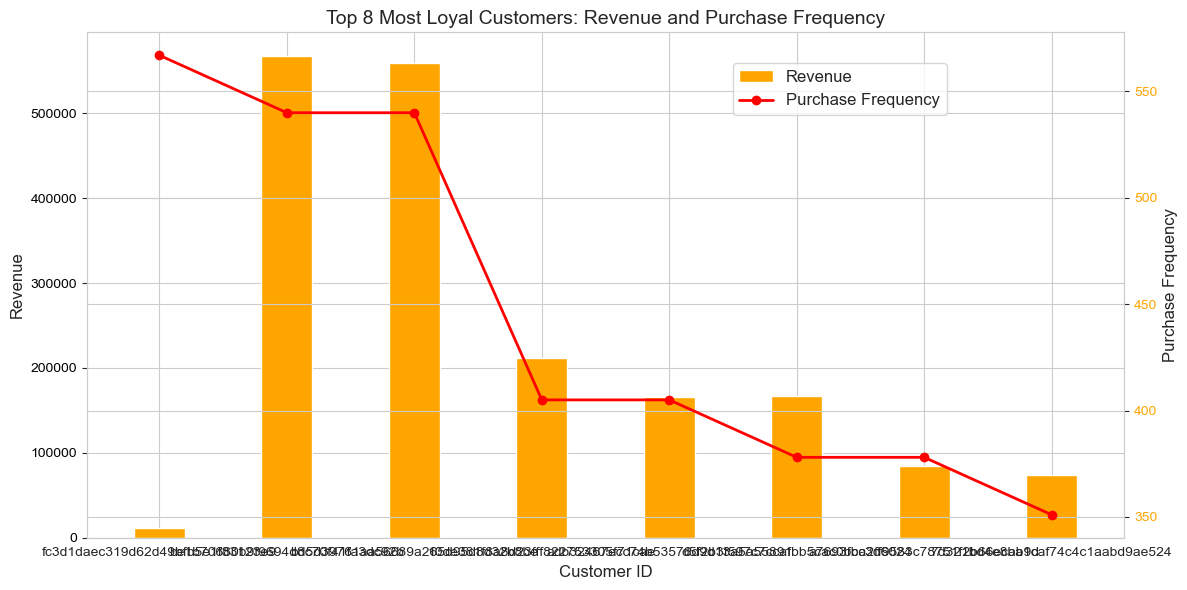

In [59]:
df_top_8 = df.head(8)

customers = df_top_8['Customer_ID']
revenue = df_top_8['Total Purchase']
frequency = df_top_8['Purchase Frequency']

fig, ax1 = plt.subplots(figsize=(12, 6))


bar_width = 0.4
ax1.bar(customers, revenue, color='orange', width=bar_width, label='Revenue')


ax1.set_ylabel('Revenue', fontsize=12)
ax1.set_xlabel('Customer ID', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')


ax2 = ax1.twinx()
ax2.plot(customers, frequency, color='red', marker='o', label='Purchase Frequency', linewidth=2)


ax2.set_ylabel('Purchase Frequency', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Top 8 Most Loyal Customers: Revenue and Purchase Frequency', fontsize=14)
fig.legend( bbox_to_anchor=(0.8, 0.9), fontsize=12)


plt.xticks(rotation=90 , ha='right')
fig.tight_layout()

plt.show()


In [52]:
## Analyze the seasonality of sales to identify peak month

query = """ SELECT 
    YEAR(O.order_purchase_timestamp) AS Year,
    MONTH(O.order_purchase_timestamp) AS Month,
    ROUND(SUM(P.payment_value), 2) AS total_sales
FROM
    orders O
        JOIN
    payments P ON O.order_id = P.order_id
Where O.order_status = 'delivered'
GROUP BY 1 , 2
ORDER BY 1 , 2"""

cur.execute(query)

data =cur.fetchall()

df = pd.DataFrame(data, columns = ['Year','Month','Total Sales'])

df

,Year,Month,Total Sales
0,2016,10,419100.39
1,2016,12,176.58
2,2017,1,1147911.03
3,2017,2,2441687.84
4,2017,3,3729324.51
5,2017,4,3518569.62
6,2017,5,5103600.57
7,2017,6,4412030.40
8,2017,7,5097635.37
9,2017,8,5814005.49


<b> Calcuate the moving average of order values for each customer over their order history </b>

In [53]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(
SELECT 
    orders.customer_id,
    orders.order_purchase_timestamp,
    payments.payment_value AS payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id','order_purchase_timestamp','payment','moving average'])
df

,customer_id,order_purchase_timestamp,payment,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


<b> Calculate the cumulative sales per month for each year</b>

In [65]:
query = """select year, month, value,
sum(value) over(order by year, month) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as year,
month(orders.order_purchase_timestamp) as month,
Round(sum(payments.payment_value),2) as value
from orders
join payments 
on orders.order_id = payments.order_id
group by year, month 
order by year, month) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','month','sales','cumulative sales'])
df

InternalError: Unread result found

In [ ]:
import calendar

df_filtered = df[(df['year'] == 2017) | (df['year'] == 2018)]

df_filtered['month_year'] = df_filtered['month'].apply(lambda x: calendar.month_abbr[x]) + '-' + df_filtered['year'].astype(str)


plt.figure(figsize=(12, 6))
plt.bar(df_filtered['month_year'], df_filtered['sales'], color='skyblue')


plt.title('Monthly Sales (Jan 2017 - Dec 2018)', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


<b> Calculate the year-over-year growth rate of total sales </b>

In [60]:
query = """with sales_rate as(
SELECT 
    YEAR(orders.order_purchase_timestamp) AS year,
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY year
)
select year, sales, ((sales - lag(sales,1) over (order by year)) / lag(sales,1) over(order by year))*100 as year_growth_rate
from sales_rate"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','sales','YOY % growth'])
df

,year,sales,YOY % growth
0,2016,534261.06,NaN
1,2017,65247720.55,12112.703758
2,2018,78297867.47,20.000924


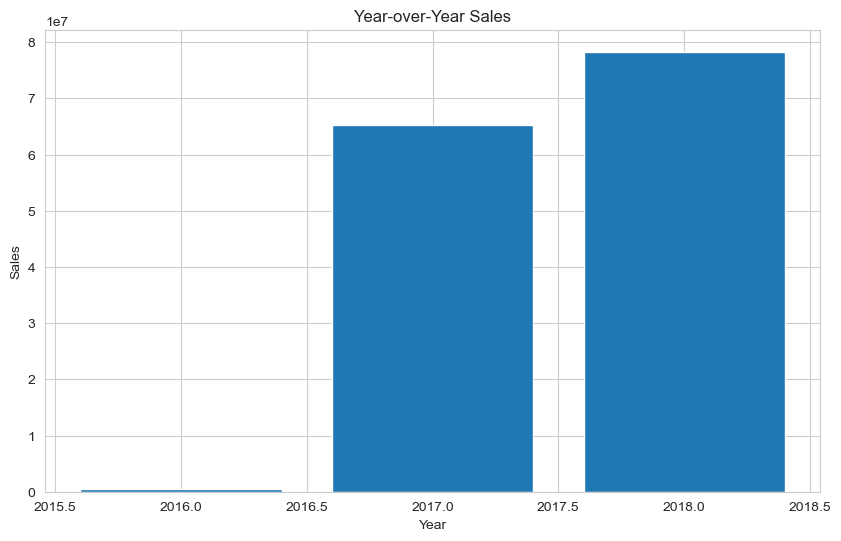

In [61]:
plt.figure(figsize = (10,6))
plt.bar(df['year'],df['sales'])
plt.title('Year-over-Year Sales')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Sales', fontsize = 10)
plt.show()


<b> Identify the top 3 customers who spent the most money in each year </b>

In [56]:
query = """With top_customers as(
select  *, 
rank() over(partition by year order by year, indi_purchase DESC) as cust_rank
from(
select year(orders.order_purchase_timestamp) year,
orders.customer_id, sum(payments.payment_value) as indi_purchase
from orders
join payments
on orders.order_id = payments.order_id
group by year, orders.customer_id) as a
)
select *
from top_customers
where cust_rank<=3"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['year','customer','payment','rank'])
df

,year,customer,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,12811.950439,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,12606.659912,2
2,2016,4a06381959b6670756de02e07b83815f,11050.020264,3
3,2017,1617b1357756262bfa56ab541c47bc16,122976.720703,1
4,2017,c6e2731c5b391845f6800c97401a43a9,62363.790527,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,60539.941406,3
6,2018,ec5b2ba62e574342386871631fafd3fc,65473.918945,1
7,2018,f48d464a0baaea338cb25f816991ab1f,62299.889648,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,43284.959473,3


<function matplotlib.pyplot.show(close=None, block=None)>

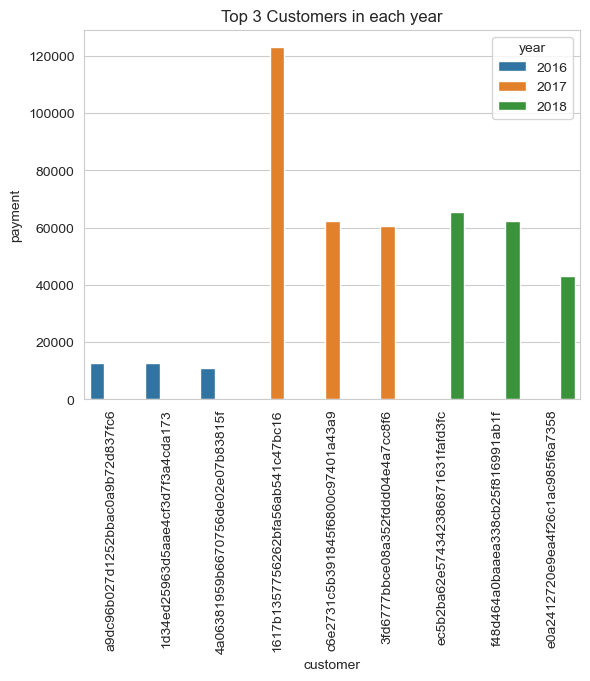

In [57]:
sns.barplot(x='customer',y='payment',data=df, hue='year')
plt.title('Top 3 Customers in each year')
plt.xticks(rotation = 90)
plt.show

In [ ]:
## Write a query to calculate the total revenue per-category, sub-category and region

query = """SELECT 
    products.product_category,
    customers.customer_state AS region,
    ROUND(SUM(payments.payment_value), 2) AS Total_Revenue
FROM
    order_items
        JOIN
    products ON order_items.product_id = products.product_id
        JOIN
    orders ON order_items.order_id = orders.order_id
        JOIN
    customers ON orders.customer_id = customers.customer_id
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY 1 , 2 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product Category','Region','Total Sales'])
df